### Import all the packages

In [1]:
from build_user_subreddit_history import read_json_list
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import random
from community import community_louvain
import matplotlib.cm as cm
from datetime import datetime
from datetime import date
import datetime as dt
import seaborn as sns
from scipy import stats
import spacy
spacy.prefer_gpu()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import statsmodels.api as sm
import statsmodels.formula.api as smf
from gensim.models import TfidfModel

# LDA Topic modeling
import json
import glob
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
#nltk
import nltk
from nltk.corpus import stopwords
#vis
import pyLDAvis
import pyLDAvis.gensim_models as gensim_models
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Select variables that I want related to the posts: time, text, date
def get_contents(sub):
    
    result_dic = {}
    
    filename = "new_data/{1}/{0}/{1}_jsonlists.gz".format(sub, 'posts')
    
    i = 0
    
    for dic in read_json_list(filename):
            result = {}
            if 'selftext' in dic:
                title = dic['title']
                text = dic['selftext']
                subreddit = dic['subreddit']
                created_time = dic['created_utc']   
                if text != '[removed]'and text !='[deleted]':
                    result['text'] = title+' '+text 
                    result['time'] = datetime.utcfromtimestamp(created_time).strftime('%Y-%m-%d %H:%M:%S')
                    result['date'] = result['time'][:10]
                    result_dic[i] = result
                    i += 1
    return result_dic

In [3]:
workfromhome = get_contents('WorkFromHome_3years')

### Preprocess the subreddits

In [4]:
workfromhome1 = []
for k,v in workfromhome.items():
    workfromhome1.append(v['text'])

In [5]:
# Lemmatization
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    raw_texts = []
    for text in texts:
        raw_texts.append(text)
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        final = re.sub('https?:[^\s]+', '', final)
        texts_out.append(final)
    return texts_out,raw_texts

In [6]:
lemmatized_texts, raw_texts = lemmatization(workfromhome1)

In [7]:
lemmatized_texts[:10]

['make easy',
 'resume example try apply home work need overhaul resume example help',
 'need home know legitimate work home site browse',
 'work home improve mental health',
 'face situation team call slack call team member hear moaning team member clueless one use mute option',
 'suggestion 2nd wfh job opportunity take 3rd shift job pretty much just require there need night so look try find else there laptop require talk very computer savvy even a+ it certification so suggestion much appreciate',
 'work work many employee',
 'use vpn satellite internet so house shopping just find really nice house work home high speed internet there vpn connect day connect remote desktop video call use vpn satellite work decent stuff remote desktop video zoom call',
 'wfh scam apply job lately get text message work home job pay hour seem little high completely unrealistic first red flag texte directly instead email message job board second red flag interview chat video chat just text couple little er

In [8]:
raw_texts[:10]

['Making it easy for everyone ',
 'Resume example? Trying to apply for at home work &amp; need to overhaul my resume. Anyone have any examples that can help me out?',
 'Need Legit Work from Home Sites Anyone know of any legitimate work from home sites that I can browse?',
 'Work from home will improve your mental health ',
 'Has anyone faced this situation in team call ? I was in slack call with my team members and heard moaning from one team member. How clueless one can be to not use the mute option ',
 "Suggestions for a 2nd WFH job.. I have the opportunity to take a 3rd shift job that pretty much just requires me to be there if needed throughout the night. So I'm looking into trying to find something else I can do while I'm there on my laptop that doesn't require talking. I'm very computer savvy and even have an A+ IT certification. So any suggestions for something I can do would be much appreciated!",
 'Why Working From Home Doesn’t Work for Many Employees ',
 "does anyone use vpn 

In [9]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

In [10]:
data_words = gen_words(lemmatized_texts)

In [11]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=30)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=30)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)


In [12]:
stopwords = stopwords.words("english")

In [13]:
word_lst = ['get','just','go','so','do','take','make','give','vs','also','let','th','amp','etc','ve',"seem", "think","look","thing","else","already","turn","way","see","say","one","come","bit","actually","set","put","sure","lot","even","maybe","whole","ensure","co"]

In [14]:
# Stop words
new_data_bigrams_trigrams = []
for lst in data_bigrams_trigrams:
    new_lst = []
    for i in lst:
        if i not in word_lst and i not in stopwords:
            new_lst.append(i)
    new_data_bigrams_trigrams.append(new_lst)

In [15]:
new_data_bigrams_trigrams = []
for lst in data_bigrams_trigrams:
    new_lst = []
    for i in lst:
        if i not in word_lst and i not in stopwords:
            if i == 'coronavirus' or i == 'pandemic':
                new_lst.append('covid')
            elif i == 'workfromhome':
                new_lst.append('wfh')
            elif i == 'remotely':
                new_lst.append('remote')
            elif i == 'stand_desk':
                new_lst.append('standing_desk')
            else:
                new_lst.append(i)
    new_data_bigrams_trigrams.append(new_lst)


In [16]:
data_bigrams_trigrams = new_data_bigrams_trigrams

In [17]:
#TF-IDF REMOVAL
id2word = corpora.Dictionary(data_bigrams_trigrams)
texts = data_bigrams_trigrams
corpus = [id2word.doc2bow(text) for text in texts]
tfidf = TfidfModel(corpus, id2word=id2word)
low_value = 0.1
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = []
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

### Topic modeling

In [18]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=12,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [19]:
# 12 topics
pyLDAvis.enable_notebook()
vis = gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.220605  0.389932       1        1  15.089553
5      0.058828  0.454485       2        1  12.253068
7      0.457505 -0.019350       3        1  11.071024
3     -0.417892 -0.096197       4        1   9.622088
9      0.157767  0.158781       5        1   8.915744
10    -0.113242 -0.002957       6        1   8.415306
2     -0.302505 -0.336118       7        1   8.249449
11    -0.054201 -0.416603       8        1   7.159516
8     -0.397932  0.180134       9        1   5.722062
0      0.155602 -0.351063      10        1   5.529031
1      0.331386 -0.236849      11        1   4.303072
4      0.345289  0.275806      12        1   3.670088, topic_info=             Term         Freq        Total Category  logprob  loglift
4            home  3216.000000  3216.000000  Default  30.0000  30.0000
9            work  3534.000000  3534.000000  Default  29.0000  29.0000
153          time  1797.000000  1797.000000  Default  28.0000  28.0000
57         remote  2515.000000  2515.000000  Default  27.0000  27.0000
32            job  2325.000000  2325.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
2392        trust    36.909933    38.139117  Topic12  -5.2435   3.2722
1309       choice    32.049034    33.278228  Topic12  -5.3848   3.2673
6712   efficiency    32.021604    33.250799  Topic12  -5.3856   3.2673
2151       submit    31.108065    32.337219  Topic12  -5.4145   3.2662
2859  financially    30.714322    31.943517  Topic12  -5.4273   3.2657

[395 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
175       2  0.992529       able
1186      3  0.993840     access
232      12  0.979999     accord
65        4  0.997931    account
66        4  0.992217    address
...     ...       ...        ...
593       4  0.996770  workspace
1004      6  0.986854      world
765       4  0.996012      worth
172       1  0.997585       year
1704     11  0.989106   year_old

[371 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 8, 4, 10, 11, 3, 12, 9, 1, 2, 5])

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=20, step=2)

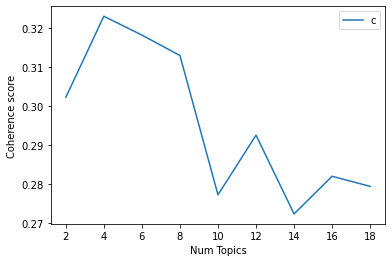

In [22]:
# Show graph
limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3023
Num Topics = 4  has Coherence Value of 0.3231
Num Topics = 6  has Coherence Value of 0.3183
Num Topics = 8  has Coherence Value of 0.313
Num Topics = 10  has Coherence Value of 0.2772
Num Topics = 12  has Coherence Value of 0.2925
Num Topics = 14  has Coherence Value of 0.2723
Num Topics = 16  has Coherence Value of 0.282
Num Topics = 18  has Coherence Value of 0.2794


### Sentiment analysis for each topic

In [24]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=raw_texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [25]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=raw_texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.2099,"remote, job, know, wfh, experience, learn, eas...",Making it easy for everyone
1,1,10.0,0.2966,"free, help, project, well, send, chair, check,...",Resume example? Trying to apply for at home wo...
2,2,6.0,0.1967,"remote, job, know, wfh, experience, learn, eas...",Need Legit Work from Home Sites Anyone know of...
3,3,4.0,0.2248,"home, hour, app, dollar, partner, internet_con...",Work from home will improve your mental health
4,4,7.0,0.2687,"use, find, try, desk, new, idea, laptop, like,...",Has anyone faced this situation in team call ?...
5,5,6.0,0.4113,"remote, job, know, wfh, experience, learn, eas...",Suggestions for a 2nd WFH job.. I have the opp...
6,6,8.0,0.2232,"work, employee, worker, productivity, study, f...",Why Working From Home Doesn’t Work for Many Em...
7,7,5.0,0.5335,"company, start, want, call, pay, video, stay, ...",does anyone use vpn through satellite internet...
8,8,10.0,0.3510,"free, help, project, well, send, chair, check,...",Another WFH Scam I have been applying for jobs...
9,9,6.0,0.2559,"remote, job, know, wfh, experience, learn, eas...",Good secondary WFH job? My job of 10 years mov...


In [26]:
print(lda_model.print_topics(num_words=5)) 

[(0, '0.056*"feel" + 0.049*"website" + 0.044*"life" + 0.042*"training" + 0.041*"task"'), (1, '0.219*"time" + 0.097*"keep" + 0.032*"customer" + 0.031*"break" + 0.030*"part"'), (2, '0.066*"covid" + 0.058*"business" + 0.029*"live" + 0.028*"income" + 0.027*"issue"'), (3, '0.050*"team" + 0.043*"people" + 0.038*"tool" + 0.037*"email" + 0.027*"account"'), (4, '0.460*"home" + 0.062*"hour" + 0.037*"app" + 0.016*"dollar" + 0.016*"partner"'), (5, '0.055*"company" + 0.051*"start" + 0.042*"want" + 0.033*"call" + 0.030*"pay"'), (6, '0.087*"remote" + 0.081*"job" + 0.038*"know" + 0.036*"wfh" + 0.023*"experience"'), (7, '0.062*"use" + 0.037*"find" + 0.035*"try" + 0.031*"desk" + 0.031*"new"'), (8, '0.324*"work" + 0.048*"employee" + 0.029*"worker" + 0.027*"productivity" + 0.024*"study"'), (9, '0.085*"money" + 0.065*"online" + 0.060*"earn" + 0.048*"good" + 0.048*"tip"'), (10, '0.062*"free" + 0.047*"help" + 0.036*"project" + 0.033*"well" + 0.032*"send"'), (11, '0.088*"day" + 0.074*"office" + 0.056*"back" +

In [27]:
topic_dic = {}
for row in range(len(df_dominant_topic)):
    if df_dominant_topic.iloc[row,2] >0.2:
        if df_dominant_topic.iloc[row,1] not in topic_dic.keys():
            topic_dic[df_dominant_topic.iloc[row,1]]=[]
        topic_dic[df_dominant_topic.iloc[row,1]].append(df_dominant_topic.iloc[row,4])

In [28]:
def sentiment_scores(sentence):
    
    result = 0
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
 
    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0.35 :
        result = "Positive"
 
    elif sentiment_dict['compound'] <= - 0.05 :
        result = "Negative"
 
    else :
        result = "Neutral"

    return result,sentiment_dict['compound']

In [29]:
topic_sentiment_dic = {}
for k,v in topic_dic.items():
    topic_sentiment_dic[k]={}
    topic_sentiment_dic[k]["Positive"] = 0
    topic_sentiment_dic[k]["Neutral"] = 0
    topic_sentiment_dic[k]["Negative"] = 0
    topic_sentiment_dic[k]["Num"] = 0    
    for i in v:
        topic_sentiment_dic[k]["Num"] += 1 
        if sentiment_scores(i)[0] =="Positive":
            topic_sentiment_dic[k]["Positive"] +=1
        elif sentiment_scores(i)[0] =="Neutral":
            topic_sentiment_dic[k]["Neutral"] +=1        
        else:
            topic_sentiment_dic[k]["Negative"] +=1    
    topic_sentiment_dic[k]["Positive Rate"] = topic_sentiment_dic[k]["Positive"]/topic_sentiment_dic[k]["Num"]
    topic_sentiment_dic[k]["Neutral Rate"] = topic_sentiment_dic[k]["Neutral"]/topic_sentiment_dic[k]["Num"]
    topic_sentiment_dic[k]["Negative Rate"] = topic_sentiment_dic[k]["Negative"]/topic_sentiment_dic[k]["Num"]
    

In [30]:
# Name of each topic
topic_name = {6:"find wfh jobs, interviews & experience for jobs",
             5:"company's requirement & work experience",
             7:"technology equipments issues",
             3:"team, coworkers & boss",
             9:"make money online & ads",
             10:"equipment (desk, chair) & health",
             2:"life style & work-life balance", # lots of topics (couples work together on one desk, choose headset, work abroad, )
             11:"back to office & physical and mental health",
             8:"surveys",
             0:"recommendation (lonely, productivity, etc.)", # lots of ads , not that good
             1:"time management", # highly related with schedule topics
             4:"home & family"
             }

In [31]:
topic_sentiment_df = pd.DataFrame(columns=['dominant topic','topic name','nums','positive rate','neutral rate','negative rate'])
for i in topic_dic.keys():
    topic_sentiment_df = topic_sentiment_df.append({'dominant topic': i,'topic name':topic_name[i],'nums':len(topic_dic[i]), 'positive rate':topic_sentiment_dic[i]["Positive Rate"] ,'neutral rate':topic_sentiment_dic[i]["Neutral Rate"],'negative rate':topic_sentiment_dic[i]["Negative Rate"]}, ignore_index=True)

In [32]:
topic_sentiment_df

,dominant topic,topic name,nums,positive rate,neutral rate,negative rate
0,6.0,"find wfh jobs, interviews & experience for jobs",1946,0.642343,0.201953,0.155704
1,10.0,"equipment (desk, chair) & health",276,0.739130,0.083333,0.177536
2,4.0,home & family,19,0.947368,0.000000,0.052632
3,7.0,technology equipments issues,747,0.686747,0.170013,0.143240
4,8.0,surveys,159,0.754717,0.106918,0.138365
5,5.0,company's requirement & work experience,747,0.586345,0.210174,0.203481
6,9.0,make money online & ads,580,0.687931,0.255172,0.056897
7,11.0,back to office & physical and mental health,183,0.562842,0.185792,0.251366
8,0.0,"recommendation (lonely, productivity, etc.)",79,0.835443,0.025316,0.139241
9,2.0,life style & work-life balance,217,0.658986,0.124424,0.216590


In [56]:
topic_sentiment_df.to_csv('topic sentiment(wfh) raw.csv')